In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pos-cash-bal/POS_CASH_balance.csv
/kaggle/input/loan-data/de_duplicated_data.csv


In [2]:
from pathlib import Path
loan_data_dir = Path('/kaggle/input/loan-data')
output_dir = Path('/kaggle/working')

In [3]:
loan_df = pd.read_csv(loan_data_dir / 'de_duplicated_data.csv')
loan_df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
loan_df.columns

Index(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT', 'TOTAL_REPAID_PER_INSTAL', 'SK_ID_CURR',
       'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'CNT_PAYMENT', 'INTEREST_RATE', 'TARGET', 'CODE_GENDER',
       'DAYS_ID_PUBLISH', 'CURR_AMT_CREDIT', 'CURR_AMT_ANNUITY',
       'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'DAYS_EMPLOYED', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE',
       'NAME_EDUCATION_TYPE', 'LIVE_CITY_NOT_WORK_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')

In [5]:
loan_df.shape

(2839754, 39)

## Filter for previous cash loans with instalment histories which were at most 3 years-old.

In [6]:
at_most_3_yr_df = loan_df[np.abs(loan_df.DAYS_INSTALMENT) <= (365 * 3)]

pct_curr_id_preserved = (len(at_most_3_yr_df.SK_ID_CURR.unique()) / len(loan_df.SK_ID_CURR.unique())) * 100
pct_prev_id_preserved = (len(at_most_3_yr_df.SK_ID_PREV.unique()) / len(loan_df.SK_ID_PREV.unique())) * 100
print(f'PCT SK_ID_CURR: {pct_curr_id_preserved}')
print(f'PCT SK_ID_PREV: {pct_prev_id_preserved}')

PCT SK_ID_CURR: 95.80176820232764
PCT SK_ID_PREV: 85.96217391304349


In [7]:
def target_mapper(target):
    if target:
        return 'Default'
    return 'No Default'

In [8]:
target_df = at_most_3_yr_df[['SK_ID_CURR', 'TARGET']].copy().drop_duplicates()
target_df['TARGET'] = target_df['TARGET'].apply(target_mapper)
target_df.groupby('TARGET').count() #There's 9439 Defaulters for now.

,SK_ID_CURR
TARGET,
Default,9439
No Default,105640


## Compute Feature 1:
## Weighted Average Interest for Previous Loans with Instalment Histories which were at most 3 years old.

In [9]:
cols_to_keep = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT', 'INTEREST_RATE']
interest_df = at_most_3_yr_df.copy()[cols_to_keep].drop_duplicates()

In [10]:
interest_df['TOTAL_AMT_CREDIT'] = interest_df \
                                    .groupby('SK_ID_CURR')['AMT_CREDIT'] \
                                    .transform(np.sum)

interest_df['WEIGHT'] = interest_df['AMT_CREDIT'] / interest_df['TOTAL_AMT_CREDIT']
interest_df['INTEREST_RATE_ADJ'] = interest_df['WEIGHT']  * interest_df['INTEREST_RATE']

interest_df['WEIGHTED_AVR_INTEREST_RATE'] = interest_df \
                                                .groupby('SK_ID_CURR')['INTEREST_RATE_ADJ'] \
                                                .transform(np.sum)

interest_feature_df = interest_df[['SK_ID_CURR', 'WEIGHTED_AVR_INTEREST_RATE']] \
                        .copy().drop_duplicates()
interest_feature_df.head()

,SK_ID_CURR,WEIGHTED_AVR_INTEREST_RATE
0,198678,45.090000
12,277601,33.370296
23,198771,40.000000
33,217553,67.426297
48,330786,35.526539


In [11]:
len(interest_feature_df.SK_ID_CURR.unique()) == len(at_most_3_yr_df.SK_ID_CURR.unique()) #sanity check

True

[Text(0.5, 1.0, 'Distribution of Weighted Average Interest Rate')]

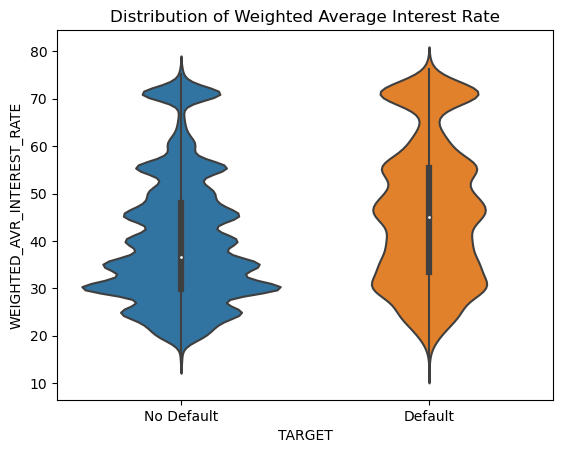

In [12]:
import seaborn as sns

viz_interest_rate_df = interest_feature_df.merge(target_df, how='inner', on=['SK_ID_CURR'])

sns.violinplot(
    data=viz_interest_rate_df, x="TARGET", y="WEIGHTED_AVR_INTEREST_RATE")\
    .set(title='Distribution of Weighted Average Interest Rate')

## Compute the following metrics:
2. Sum of Money Owed for instalments which were at most 5 years old.
3. Number of Late Payment streaks for instalments which were at most 5 years old.
4. Number of Consecutive Partial Payment streaks for instalments which were at most 5 years old.
5. Compute loan interest rates.
Note: all these features  are only relevant for curr loan ids in five_yr_instal df

## Compute Feature 2:
## Mean of Days Past Due (DPD) for instalments which were at most 3 years old.

**DAYS_ENTRY_PAYMENT**: The actual which a borrower paid his or her instalment. <br>
For eg: if **DAYS_ENTRY_PAYMENT** is -10, a borrower repaid his or her instalment 10 days prior to current loan application.

**DAYS_INSTALMENT**: The deadline to pay an instalment. <br>
For eg: if **DAYS_INSTALMENT** is -20, a borrower needs to repay his or her instalment 20 days prior to current loan application. <br>

In our example, **DAYS_ENTRY_PAYMENT** occurred after **DAYS_INSTALMENT**, the borrower was late in his or her repayment.

In [13]:
cols_to_keep = ['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 
                'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 
                'AMT_PAYMENT']
three_yr_instal_copy = at_most_3_yr_df \
                        .copy() \
                        .sort_values(by=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])[cols_to_keep]

In [14]:
three_yr_instal_copy['DPD'] = three_yr_instal_copy['DAYS_ENTRY_PAYMENT'] - three_yr_instal_copy['DAYS_INSTALMENT']
three_yr_instal_copy.head()

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DPD
0,198678,1000011,1,-435.0,-438.0,92435.0,92435.0,-3.0
1,198678,1000011,2,-405.0,-411.0,92435.0,92435.0,-6.0
2,198678,1000011,3,-375.0,-377.0,92435.0,92435.0,-2.0
3,198678,1000011,4,-345.0,-346.0,92435.0,92435.0,-1.0
4,198678,1000011,5,-315.0,-314.0,92435.0,92435.0,1.0


In [15]:
dpd_feature_df = three_yr_instal_copy \
                    .groupby(['SK_ID_CURR'])['DPD'].mean().reset_index()

dpd_feature_df.rename(
    {'DPD': 'MEAN_DPD'}, 
    axis=1, inplace=True
)
dpd_feature_df.head()

,SK_ID_CURR,MEAN_DPD
0,100003,-4.428571
1,100006,-23.000000
2,100007,-5.071429
3,100008,-9.250000
4,100011,-6.178571


In [16]:
set(dpd_feature_df.SK_ID_CURR.unique()) == set(at_most_3_yr_df.SK_ID_CURR.unique()) #sanity check

True

In [17]:
viz_dpd_df = dpd_feature_df.merge(target_df, how='inner', on=['SK_ID_CURR'])

<AxesSubplot:xlabel='TARGET', ylabel='MEAN_DPD'>

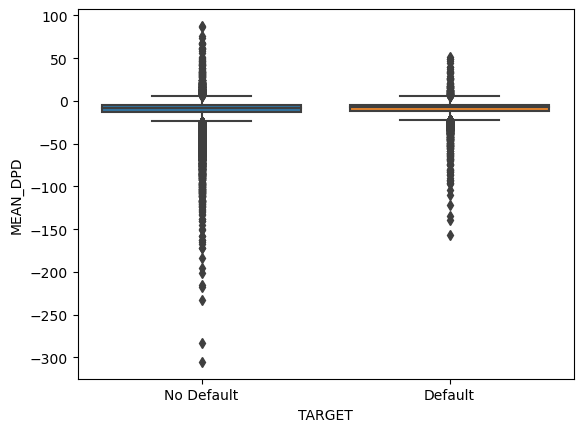

In [18]:
sns.boxplot(data=viz_dpd_df, x="TARGET", y="MEAN_DPD")

<AxesSubplot:xlabel='MEAN_DPD', ylabel='Count'>

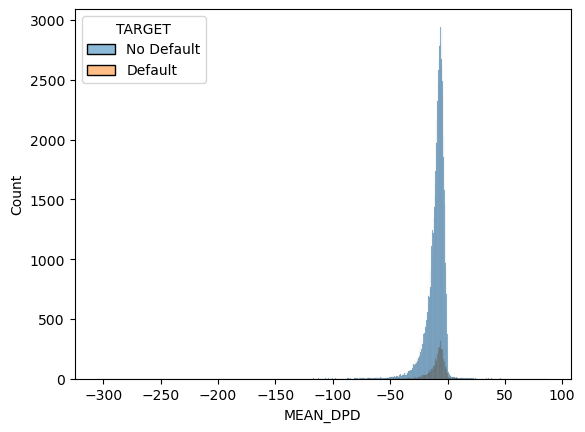

In [19]:
sns.histplot(data=viz_dpd_df, x="MEAN_DPD", hue="TARGET")

## Compute Feature 3: 
## Sum of Money Owed
- Consider weighted average of money owed.
- Using PV to compute money owed?

In [20]:
three_yr_instal_copy.shape

(2247053, 8)

In [21]:
cond = (three_yr_instal_copy.AMT_INSTALMENT > three_yr_instal_copy.AMT_PAYMENT) & (three_yr_instal_copy.DPD > 0)
late_and_partial_payments = three_yr_instal_copy[cond]

test_1_sum_payment = late_and_partial_payments.groupby(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()

In [22]:
instal_1 = late_and_partial_payments.copy()[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT']].drop_duplicates()

test_1 = test_1_sum_payment.merge(instal_1, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

test_1['MONEY_OWED'] = test_1['AMT_INSTALMENT'] - test_1['AMT_PAYMENT'] #find out for late payment, who owes money

test_1[test_1.MONEY_OWED < 0] #

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,AMT_PAYMENT,AMT_INSTALMENT,MONEY_OWED


In [23]:
#double check for dpd < 0, are all instalments repaid.
others = three_yr_instal_copy[~cond]

test_2_sum_payment = others.groupby(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()

In [24]:
instal_2 = others.copy()[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT']].drop_duplicates()

test_2 = test_2_sum_payment.merge(instal_2, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

test_2['MONEY_OWED'] = test_2['AMT_INSTALMENT'] - test_2['AMT_PAYMENT'] #find out for timely payment, who owes money, no money, prepays

test_2[test_2.MONEY_OWED == 0] #

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,AMT_PAYMENT,AMT_INSTALMENT,MONEY_OWED
0,100003,1810518,1,98357.0,98357.0,0.0
1,100003,1810518,2,98357.0,98357.0,0.0
2,100003,1810518,3,98357.0,98357.0,0.0
3,100003,1810518,4,98357.0,98357.0,0.0
4,100003,1810518,5,98357.0,98357.0,0.0
...,...,...,...,...,...,...
2126436,456255,2631384,16,27490.0,27490.0,0.0
2126439,456255,2631384,19,27490.0,27490.0,0.0
2126440,456255,2631384,21,27490.0,27490.0,0.0
2126442,456255,2631384,23,27490.0,27490.0,0.0


In [25]:
combined = pd.concat([test_1, test_2])

money_owed_feature = combined.groupby(['SK_ID_CURR'])['MONEY_OWED'].mean().reset_index()
money_owed_feature

,SK_ID_CURR,MONEY_OWED
0,100003,0.000000
1,100006,0.000000
2,100007,539.976190
3,100008,0.000000
4,100011,4470.714286
...,...,...
115074,456241,0.000000
115075,456244,2026.451613
115076,456245,0.000000
115077,456248,0.000000


In [26]:
combined.head()

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,AMT_PAYMENT,AMT_INSTALMENT,MONEY_OWED
0,100007,1940724,1,22656.0,22679.0,23.0
1,100011,2794143,22,27193.0,31295.0,4102.0
2,100011,2794143,25,30629.0,31295.0,666.0
3,100011,2794143,27,30219.0,31295.0,1076.0
4,100011,2794143,29,29810.0,31295.0,1485.0


In [27]:
viz_money_owed_df = money_owed_feature.merge(target_df, how='inner', on=['SK_ID_CURR'])

[Text(0.5, 1.0, 'Distribution of MONEY_OWED')]

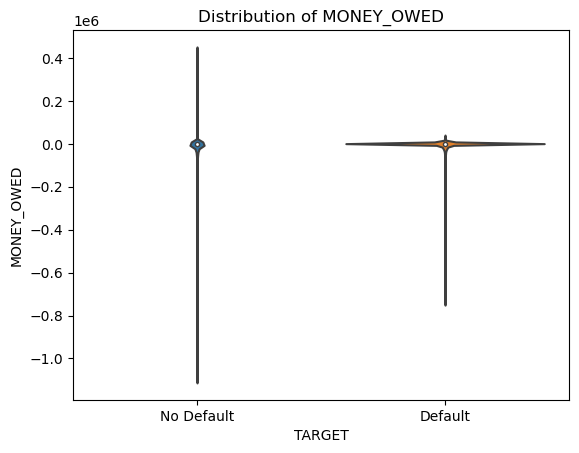

In [28]:
sns.violinplot(
    data=viz_money_owed_df, x="TARGET", y="MONEY_OWED")\
    .set(title='Distribution of MONEY_OWED')

<AxesSubplot:xlabel='TARGET', ylabel='MONEY_OWED'>

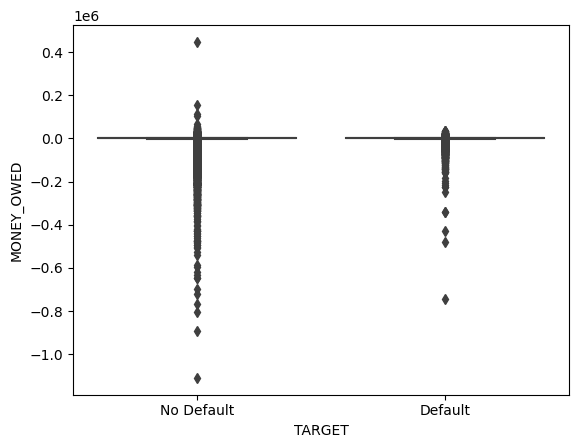

In [29]:
sns.boxplot(data=viz_money_owed_df, x="TARGET", y="MONEY_OWED")

## Compute Feature 4: 
## Quick Ratio: 
1. Correct monthly income **AMT_INCOME_TOTAL**:
    1. Check who is currently unemployed: **DAYS_EMPLOYED** == 365_243 and **NAME_INCOME_TYPE == Unemployed**, set their monthly income, **AMT_INCOME_TOTAL** as 0.
    2. Explanation of **DAYS_EMPLOYED**:
        1. If **DAYS_EMPLOYED** == 0, then borrower started current employment on the date of current loan application.
        2. If **DAYS_EMPLOYED** == -10, then borrower started current employment 10 days prior to current loan application.
        3. If **DAYS_EMPLOYED** == 365_243, then borrower is unemployed indefinitely.
        
2. Extract monthly obligation:
    1. Sum **CURR_AMT_ANNUITY** with latest **AMT_INSTALMENT** of all active previous loans.
    2. If there are no active previous loans, then let monthly obligation be **CURR_AMT_ANNUITY**.
    3. If **CURR_AMT_ANNUITY** is missing and there are no more active previous loans, then use average of latest **AMT_INSTALMENT** of completed loans.

3. Compute Quick Ratio as:
    1. **AMT_INCOME_TOTAL** / monthly obligation.

In [30]:
#to set amt_income_total == 0, need to check if there no "bad income for that month"
cols_to_keep = ['SK_ID_CURR', 'DAYS_EMPLOYED','NAME_INCOME_TYPE', 
                'AMT_INCOME_TOTAL', 'CURR_AMT_CREDIT', 'CURR_AMT_ANNUITY']

income_df = at_most_3_yr_df \
            .copy()[cols_to_keep] \
            .drop_duplicates()

print(income_df.shape)
income_df.head()

(115079, 6)


,SK_ID_CURR,DAYS_EMPLOYED,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY
0,198678,-1145,Commercial associate,157500.0,1314117.0,38551.5
12,277601,365243,Pensioner,67500.0,254700.0,14350.5
23,198771,-152,Working,90000.0,1159515.0,34033.5
33,217553,-2556,Working,54000.0,277969.5,18706.5
48,330786,-1629,Working,292500.0,263686.5,19107.0


In [31]:
#define unmployed as DAYS_EMPLOYED is indefinite and income-type == 'Unemployed'
#assume unemployed has no income.
is_unemployed = (income_df \
                     .NAME_INCOME_TYPE == 'Unemployed')

unemployed_df = income_df[is_unemployed]

unemployed_ids = unemployed_df \
                    .SK_ID_CURR.unique()

unemployed_df['AMT_INCOME_TOTAL'] = 0 #need to 2x check this logic

print(unemployed_df.shape)
unemployed_df.head()

(14, 6)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,SK_ID_CURR,DAYS_EMPLOYED,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY
186352,143454,365243,Unemployed,0,585000.0,26892.0
704656,127729,365243,Unemployed,0,783000.0,22306.5
736787,303289,365243,Unemployed,0,571500.0,16281.0
740513,343178,365243,Unemployed,0,387000.0,22234.5
955566,347145,365243,Unemployed,0,886500.0,25384.5


In [32]:
has_income_df = income_df[~(income_df.SK_ID_CURR.isin(unemployed_ids))]
has_income_df.shape

(115065, 6)

In [33]:
income_df = pd.concat([has_income_df, unemployed_df])
print(income_df.shape)
income_df[income_df.AMT_INCOME_TOTAL < 0] #ensure not negative income

(115079, 6)


,SK_ID_CURR,DAYS_EMPLOYED,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY


In [34]:
income_df.isnull().sum()

SK_ID_CURR          0
DAYS_EMPLOYED       0
NAME_INCOME_TYPE    0
AMT_INCOME_TOTAL    0
CURR_AMT_CREDIT     0
CURR_AMT_ANNUITY    4
dtype: int64

In [35]:
pos_cash_df = pd.read_csv('/kaggle/input/pos-cash-bal/POS_CASH_balance.csv')

completed_loans = pos_cash_df[
                    pos_cash_df.NAME_CONTRACT_STATUS == 'Completed'] \
                    .filter(items=['SK_ID_PREV', 'NAME_CONTRACT_STATUS'])
completed_loans_id = completed_loans.SK_ID_PREV.unique()

In [36]:
cols_to_keep = ['SK_ID_CURR', 'SK_ID_PREV', 
                'NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT', 
                'AMT_ANNUITY']
instal_df = at_most_3_yr_df.copy()[cols_to_keep].drop_duplicates()

is_active = ~(instal_df.SK_ID_PREV.isin(completed_loans_id))
active_instal_df = instal_df[is_active] #filter for prev loans which are not completed, these loans are assumed to be still active.
active_instal_df.shape

(838633, 5)

In [37]:
#for each active previous loan, get their latest instalment number and the corresponding amt_instalment
latest_instal_num = active_instal_df \
                    .groupby(by=['SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'].max().reset_index()

latest_instal_info = latest_instal_num \
                    .merge(active_instal_df, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])
latest_instal_info.head()

,SK_ID_PREV,NUM_INSTALMENT_NUMBER,SK_ID_CURR,AMT_INSTALMENT,AMT_ANNUITY
0,1000050,10,198771,13833.0,13833.450
1,1000082,23,330786,59074.0,59074.335
2,1000088,12,120403,43434.0,43467.885
3,1000117,23,335112,16818.0,48698.595
4,1000140,12,148166,22443.0,22312.080


In [38]:
monthly_obligation_for_prev = latest_instal_info \
                                .groupby(['SK_ID_CURR'])['AMT_INSTALMENT'].sum().reset_index()

monthly_obligation_for_prev.rename( \
    {'AMT_INSTALMENT': 'PREV_TOTAL_INSTAL'}, axis=1, inplace=True)

monthly_obligation_for_prev.head()

,SK_ID_CURR,PREV_TOTAL_INSTAL
0,100007,16038.0
1,100027,21554.0
2,100043,25973.0
3,100048,57467.0
4,100053,10720.0


In [39]:
income_and_monthly_ob = income_df \
                        .merge(monthly_obligation_for_prev, how='left', on=['SK_ID_CURR'])

income_and_monthly_ob['PREV_TOTAL_INSTAL'] = income_and_monthly_ob['PREV_TOTAL_INSTAL'].fillna(0)
income_and_monthly_ob.isnull().sum()

SK_ID_CURR           0
DAYS_EMPLOYED        0
NAME_INCOME_TYPE     0
AMT_INCOME_TOTAL     0
CURR_AMT_CREDIT      0
CURR_AMT_ANNUITY     4
PREV_TOTAL_INSTAL    0
dtype: int64

In [40]:
income_and_monthly_ob[ \
    income_and_monthly_ob.CURR_AMT_ANNUITY.isnull()]

,SK_ID_CURR,DAYS_EMPLOYED,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,PREV_TOTAL_INSTAL
30935,187985,-2450,Working,144000.0,219249.0,NaN,28457.0
49478,243648,-3540,Working,202500.0,929088.0,NaN,0.0
57042,364022,-1478,Commercial associate,315000.0,628069.5,NaN,46699.0
66978,377174,-2885,State servant,157500.0,792000.0,NaN,68418.0


In [41]:
#since these 4 borrowers have no recent default, set their CURR_AMT_ANNUITY to 0
target_df[
    target_df
    .SK_ID_CURR
    .isin([18_79_85, 24_36_48, 36_40_22, 37_71_74])]

,SK_ID_CURR,TARGET
1026600,187985,No Default
1551156,243648,No Default
1740375,364022,No Default
1972825,377174,No Default


In [42]:
"""
    Impute monthly obligation for 24_36_48 using latest instalment number
    
"""
is_completed = (instal_df.SK_ID_PREV.isin(completed_loans_id))
completed_instal_df = instal_df[is_completed & (instal_df.SK_ID_CURR == 24_36_48)]

latest_instal_24_36_48 = completed_instal_df \
                        .groupby(['SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'] \
                        .max().reset_index()

latest_instal_info_24_36_48 = latest_instal_24_36_48 \
                    .merge(completed_instal_df, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

mean_instal = latest_instal_info_24_36_48['AMT_INSTALMENT'].mean()

#row index for SK_ID_CURR == 24_36_48
row_index_for_24_36_48 = income_and_monthly_ob[income_and_monthly_ob.SK_ID_CURR == 24_36_48].index.item()
income_and_monthly_ob.at[row_index_for_24_36_48, 'PREV_TOTAL_INSTAL'] = mean_instal #36_875 is the row index
print(income_and_monthly_ob.shape)

(115079, 7)


In [43]:
income_and_monthly_ob[income_and_monthly_ob.SK_ID_CURR.isnull()]

,SK_ID_CURR,DAYS_EMPLOYED,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,CURR_AMT_CREDIT,CURR_AMT_ANNUITY,PREV_TOTAL_INSTAL


In [44]:
income_and_monthly_ob['CURR_AMT_ANNUITY'] = income_and_monthly_ob['CURR_AMT_ANNUITY'].fillna(0)

In [45]:
income_and_monthly_ob['TOTAL_MONTHLY_OBLIGATION'] = income_and_monthly_ob['CURR_AMT_ANNUITY'] \
                                                + income_and_monthly_ob['PREV_TOTAL_INSTAL']
income_and_monthly_ob['QUICK_RATIO'] = np.round( \
            income_and_monthly_ob['AMT_INCOME_TOTAL'] / income_and_monthly_ob['TOTAL_MONTHLY_OBLIGATION'], 2)

In [46]:
set(income_and_monthly_ob.SK_ID_CURR.unique()) \
    == set(at_most_3_yr_df.SK_ID_CURR.unique()) #sanity check

True

[Text(0.5, 1.0, 'Distribution of QUICK_RATIO')]

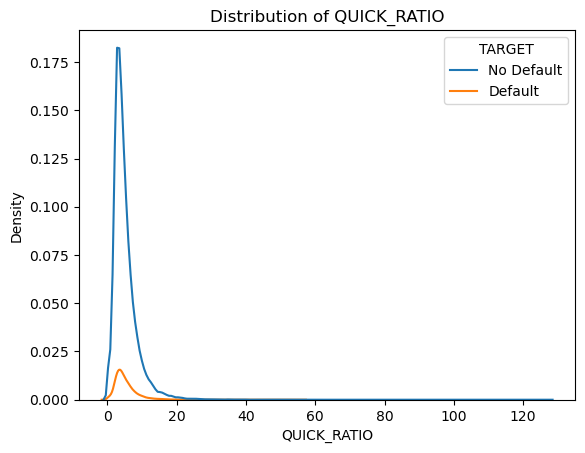

In [47]:
income_and_monthly_ob = income_and_monthly_ob \
                        .filter(items=['SK_ID_CURR', 'QUICK_RATIO'])

viz_quick_ratio_df = income_and_monthly_ob \
                        .merge(target_df, how='inner', on=['SK_ID_CURR'])

sns.kdeplot(
    data=viz_quick_ratio_df, x='QUICK_RATIO', hue='TARGET')\
    .set(title='Distribution of QUICK_RATIO')

[Text(0.5, 1.0, 'Distribution of QUICK_RATIO')]

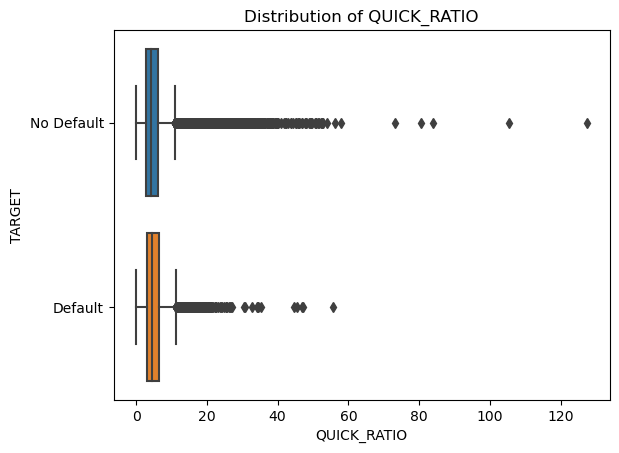

In [48]:
sns.boxplot(
    data=viz_quick_ratio_df, x='QUICK_RATIO', y='TARGET')\
    .set(title='Distribution of QUICK_RATIO')

In [49]:
print(income_and_monthly_ob.shape)
print(dpd_feature_df.shape)
print(money_owed_feature.shape)
print(dpd_feature_df.shape)
print(interest_feature_df.shape)

(115079, 2)
(115079, 2)
(115079, 2)
(115079, 2)
(115079, 2)


### Compute Prepayment Losses/Default Losses/Penalty Imposed for Completed Loans (for Business Intelligence)
Steps:
1. Get all Completed Cash loans information from pos_cash_balance.
2. Get all **SK_ID_PREV** with completed instalment information. I.e **Unique** count of instalment number == **CNT_INSTALMENT** from pos_cash_balance.

Definition of Prepayment:
1. **CNT_INSTALMENT < CNT_PAYMENT**.
2. **TOTAL_REPAID_PER_LOAN < Future Value (FV) of Loan**.

Definition of Default Losses:
1. **CNT_INSTALMENT > CNT_PAYMENT**.
2. **TOTAL_REPAID_PER_LOAN < FV of Loan**.

Definition of Late Penalty:
1. **CNT_INSTALMENT > CNT_PAYMENT**.
2. **TOTAL_REPAID_PER_LOAN > FV of Loan**.

In [50]:
pos_cash_df.NAME_CONTRACT_STATUS.unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'XNA',
       'Amortized debt'], dtype=object)

In [51]:
pos_cash_df = pd.read_csv('/kaggle/input/pos-cash-bal/POS_CASH_balance.csv')
completed_loans = pos_cash_df[pos_cash_df.NAME_CONTRACT_STATUS == 'Completed'] \
                    .filter(['SK_ID_PREV', 'CNT_INSTALMENT']) \
                    .rename({'CNT_INSTALMENT': 'NUM_INSTALMENT_NUMBER'}, axis=1)

In [52]:
"""
    get completed loans with at most 3 year histories 
    and final instalment number (CNT_INSTALMENT) from pos_cash_df
    
"""
final_instal_num_df = at_most_3_yr_df \
                    .merge(completed_loans, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']) \
                    .filter(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

In [53]:
count_instals = loan_df[loan_df.SK_ID_PREV.isin(final_instal_num_df.SK_ID_PREV)] \
    .groupby(['SK_ID_PREV'])['NUM_INSTALMENT_NUMBER'] \
    .nunique() \
    .reset_index() \
    .rename({'NUM_INSTALMENT_NUMBER': 'CNT_INSTALS'}, axis=1)
    
count_instals.head()

,SK_ID_PREV,CNT_INSTALS
0,1000011,12
1,1000027,6
2,1000067,3
3,1000086,7
4,1000116,18


In [54]:
inter_df = count_instals.merge(final_instal_num_df, how='inner', on=['SK_ID_PREV'])
#to ensure count of instalment payments == final instalment number, hence we pick SK_ID_PREV which met this condition
good_sk_id_prevs = inter_df[inter_df.CNT_INSTALS == inter_df.NUM_INSTALMENT_NUMBER].SK_ID_PREV.unique() 

In [55]:
total_repaid = loan_df[loan_df.SK_ID_PREV.isin(good_sk_id_prevs)] \
                        .groupby(['SK_ID_CURR', 'SK_ID_PREV', 'AMT_ANNUITY', 'CNT_PAYMENT', 'TARGET', 'AMT_CREDIT'])['TOTAL_REPAID_PER_INSTAL'] \
                        .sum().reset_index() \
                        .rename({'TOTAL_REPAID_PER_INSTAL': 'TOTAL_REPAID_PER_LOAN'}, axis=1)
total_repaid.head()

,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,CNT_PAYMENT,TARGET,AMT_CREDIT,TOTAL_REPAID_PER_LOAN
0,100003,1810518,98356.995,12.0,0,1035882.0,1150977.0
1,100006,2078043,24246.000,48.0,0,675000.0,691787.0
2,100007,1940724,22678.785,12.0,0,215865.0,294634.0
3,100007,2001242,16509.600,18.0,0,180000.0,280206.0
4,100008,2613879,25309.575,30.0,0,501975.0,609388.0


In [56]:
total_repaid = total_repaid \
                .merge(final_instal_num_df, how='inner', on=['SK_ID_PREV']) \
                .rename({'NUM_INSTALMENT_NUMBER': 'FINAL_INSTAL_NUM'}, axis=1) \

total_repaid['AMT_ANNUITY'] = total_repaid['AMT_ANNUITY'].round()
total_repaid['FV'] = total_repaid['AMT_ANNUITY'] \
                        * total_repaid['CNT_PAYMENT']

total_repaid.head()

,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,CNT_PAYMENT,TARGET,AMT_CREDIT,TOTAL_REPAID_PER_LOAN,FINAL_INSTAL_NUM,FV
0,100003,1810518,98357.0,12.0,0,1035882.0,1150977.0,7,1180284.0
1,100006,2078043,24246.0,48.0,0,675000.0,691787.0,1,1163808.0
2,100007,1940724,22679.0,12.0,0,215865.0,294634.0,12,272148.0
3,100007,2001242,16510.0,18.0,0,180000.0,280206.0,17,297180.0
4,100008,2613879,25310.0,30.0,0,501975.0,609388.0,8,759300.0


In [57]:
#Prepaid losses for Completed loans. FV stands for Future Values

is_repaid = (total_repaid.TOTAL_REPAID_PER_LOAN > total_repaid.AMT_CREDIT) \
            & (total_repaid.TOTAL_REPAID_PER_LOAN < total_repaid.FV) \
            & (total_repaid.FINAL_INSTAL_NUM < total_repaid.CNT_PAYMENT)
prepaid = total_repaid[is_repaid]
prepaid['PREPAID_LOSSES'] = prepaid['FV'] - prepaid['TOTAL_REPAID_PER_LOAN']
prepaid.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,CNT_PAYMENT,TARGET,AMT_CREDIT,TOTAL_REPAID_PER_LOAN,FINAL_INSTAL_NUM,FV,PREPAID_LOSSES
0,100003,1810518,98357.0,12.0,0,1035882.0,1150977.0,7,1180284.0,29307.0
1,100006,2078043,24246.0,48.0,0,675000.0,691787.0,1,1163808.0,472021.0
3,100007,2001242,16510.0,18.0,0,180000.0,280206.0,17,297180.0,16974.0
4,100008,2613879,25310.0,30.0,0,501975.0,609388.0,8,759300.0,149912.0
5,100023,2454202,16822.0,24.0,0,239242.5,282286.0,4,403728.0,121442.0


In [59]:
prepaid.shape

(85729, 10)

In [66]:
#Defaut losses for completed loans: takes longer than expected and FV > TOTAL_REPAID_PER_LOAN

is_longer_than_expected = (total_repaid.FINAL_INSTAL_NUM \
                            > total_repaid.CNT_PAYMENT) #takes longer than expected

is_smaller_than_FV = (total_repaid.FV > total_repaid.TOTAL_REPAID_PER_LOAN) \
                        & (total_repaid.TOTAL_REPAID_PER_LOAN > total_repaid.AMT_CREDIT)

defaulted = total_repaid[is_longer_than_expected & is_smaller_than_FV]
defaulted['DEFAULT_LOSSES'] = defaulted['FV'] - defaulted['TOTAL_REPAID_PER_LOAN']
defaulted.head() #loss in coupon payment

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,CNT_PAYMENT,TARGET,AMT_CREDIT,TOTAL_REPAID_PER_LOAN,FINAL_INSTAL_NUM,FV,DEFAULT_LOSSES
6690,120356,2439869,9612.0,18.0,0,114273.0,170675.0,19,173016.0,2341.0
8620,126044,2283851,80015.0,18.0,0,1033123.5,1389781.0,19,1440270.0,50489.0
14631,143399,2822186,14495.0,30.0,0,301135.5,432291.0,31,434850.0,2559.0
15951,147453,2282812,20750.0,12.0,0,202500.0,240129.0,13,249000.0,8871.0
27343,181862,2069880,28743.0,24.0,0,491580.0,689670.0,25,689832.0,162.0


In [68]:
defaulted = defaulted.merge(loan_df.filter(['SK_ID_PREV', 'AMT_GOODS_PRICE']).drop_duplicates(), how='inner', on=['SK_ID_PREV'])
defaulted['IS_INSURED'] = defaulted['AMT_CREDIT'] > defaulted['AMT_GOODS_PRICE']

In [69]:
#late payment penalty
late_but_repaid = total_repaid[is_longer_than_expected & (total_repaid.TOTAL_REPAID_PER_LOAN > total_repaid.FV)]
late_but_repaid['PENALTY_IMPOSED'] = late_but_repaid['TOTAL_REPAID_PER_LOAN'] -  late_but_repaid['FV']
late_but_repaid.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,SK_ID_PREV,AMT_ANNUITY,CNT_PAYMENT,TARGET,AMT_CREDIT,TOTAL_REPAID_PER_LOAN,FINAL_INSTAL_NUM,FV,PENALTY_IMPOSED
330,100919,2369733,17226.0,18.0,0,247500.0,312003.0,19,310068.0,1935.0
616,101680,2745918,14540.0,12.0,0,135000.0,175080.0,13,174480.0,600.0
893,102525,2805746,19567.0,18.0,0,234256.5,413192.0,19,352206.0,60986.0
1238,103646,1308849,16820.0,24.0,0,239238.0,484365.0,25,403680.0,80685.0
1721,105166,1772839,8676.0,6.0,0,46485.0,52792.0,7,52056.0,736.0


In [70]:
late_but_repaid.to_csv(output_dir / 'late_but_repaid.csv', index=False)
prepaid.to_csv(output_dir / 'prepaid.csv', index=False)
defaulted.to_csv(output_dir / 'defaulted.csv', index=False)

In [71]:
defaulted \
    .filter(['SK_ID_CURR', 'TARGET']) \
    .drop_duplicates() \
    .groupby('TARGET') \
    .count()

,SK_ID_CURR
TARGET,
0,24
1,1


In [72]:
late_but_repaid \
    .filter(['SK_ID_CURR', 'TARGET']) \
    .drop_duplicates() \
    .groupby('TARGET') \
    .count()

,SK_ID_CURR
TARGET,
0,223
1,15


In [73]:
prepaid \
    .filter(['SK_ID_CURR', 'TARGET']) \
    .drop_duplicates() \
    .groupby('TARGET') \
    .count()

,SK_ID_CURR
TARGET,
0,53484
1,4966


### Compute Frequency of Late Payments
1. A payment can be 1 late payment or a streak of consecutive late payments. See [source](https://joshdevlin.com/blog/calculate-streaks-in-pandas/) and see **compute_total_late_payment** function.
2. Create a new column called is_late.
3. Based on our formula for Days Past Due, is_late if True is Days Past Due is Positive.

In [ ]:
def compute_total_late_payment(instal_info:pd.DataFrame) -> pd.DataFrame:
    """
        Computes number of late payments (can be just 1 late payment or a streak of late payments)
        for just 1 previous loan as denoted by SK_ID_PREV.
        
        Parameters:
        -----------
            instal_info (pd.DataFrame): 
                A dataframe of instalment history for a current borrower for 1 previous loan.
                instal_info must contain the following information:
                    1. SK_ID_CURR.
                    2. SK_ID_PREV.
                    3. IS_LATE.
        
        Returns:
       ----------
       A DataFrame containing 3 pieces of information:
       1. Cumulative count of streaks of late payments for a previous loan.
       2. SK_ID_CURR.
       3. SK_ID_PREV.
       
    """
    instal_info['grouper'] = (instal_info.IS_LATE != instal_info.IS_LATE.shift()).cumsum()
    subset = instal_info[['grouper', 'IS_LATE']]
    
    subset['streaks_count'] = subset.groupby('grouper').cumsum()
    subset['start_of_streak'] = (subset['streaks_count'] == 1) | (subset['streaks_count'] == 0)
    subset['end_of_streak'] = (subset['streaks_count'].shift(-1) == 1) | (subset['streaks_count'].shift(-1) == 0)| (subset['streaks_count'].shift(-1).isnull())
    
    total_late_payments = subset[subset['end_of_streak']]['streaks_count'].sum()
    
    sk_id_curr = instal_info['SK_ID_CURR'].unique()[0]
    sk_id_prev = instal_info['SK_ID_PREV'].unique()[0]
    
    new_data = {'SK_ID_CURR': [sk_id_curr], 
                'SK_ID_PREV': [sk_id_prev], 
                'total_late_payment': [total_late_payments]}
    
    return pd.DataFrame.from_dict(new_data)

In [ ]:
cols_to_show = ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_PAST_DUE']
instal_copy = three_yr_instal_1.copy()[cols_to_show]
instal_copy['IS_LATE'] = instal_copy['DAYS_PAST_DUE'] > 0
instal_copy.head()

In [ ]:
"""

total_late_payments = []

count = 0
for sk_id_prev in instal_copy.SK_ID_PREV.unique():
    prev_loan_df = instal_copy[instal_copy.SK_ID_PREV == sk_id_prev]
    late_payment_df = compute_total_late_payment(prev_loan_df[['SK_ID_PREV', 'SK_ID_CURR', 'IS_LATE']])
    total_late_payments.append(late_payment_df)
    count += 1
    if count % 10_000 == 0:
        print(count)

late_payments_df = pd.concat(total_late_payments)
late_payments_df.head()
"""

In [ ]:
late_payments_df.rename({'total_late_payment': 'total_late_payments_freq'}, axis=1, inplace=True)
late_payments_df.to_csv(output_dir / 'late_instal_payments_count.csv', index=False)
late_payments_df.head()

### Compute Frequency of Partial Repayment of Instalments
1. Computation is similar to Frequency of Late Payments.
2. I only considered amount of money owed which exceed 100 dollars.

In [ ]:
def compute_total_partial_payment(instal_info:pd.DataFrame) -> pd.DataFrame:
    """
        Computes number of partial instalment payments (can be just 1 partial payment or a streak of partial payments)
        for just 1 previous loan as denoted by SK_ID_PREV.
        
        Parameters:
        -----------
            instal_info (pd.DataFrame): 
                A dataframe of instalment history for a current borrower for 1 previous loan.
                instal_info must contain the following information:
                    1. SK_ID_CURR.
                    2. SK_ID_PREV.
                    3. IS_PARTIAL_REPAYMENT.
        
        Returns:
       ----------
       A DataFrame containing 3 pieces of information:
       1. Cumulative count of streaks of partial payments for a previous loan.
       2. SK_ID_CURR.
       3. SK_ID_PREV.
       
    """
    instal_info['grouper'] = (instal_info.IS_PARTIAL_REPAYMENT != instal_info.IS_PARTIAL_REPAYMENT.shift()).cumsum()
    subset = instal_info[['grouper', 'IS_PARTIAL_REPAYMENT']]
    
    subset['streaks_count'] = subset.groupby('grouper').cumsum()
    subset['start_of_streak'] = (subset['streaks_count'] == 1) | (subset['streaks_count'] == 0)
    subset['end_of_streak'] = (subset['streaks_count'].shift(-1) == 1) | (subset['streaks_count'].shift(-1) == 0)| (subset['streaks_count'].shift(-1).isnull())
    
    total_late_payments = subset[subset['end_of_streak']]['streaks_count'].sum()
    
    sk_id_curr = instal_info['SK_ID_CURR'].unique()[0]
    sk_id_prev = instal_info['SK_ID_PREV'].unique()[0]
    
    new_data = {'SK_ID_CURR': [sk_id_curr], 
                'SK_ID_PREV': [sk_id_prev], 
                'total_partial_payment': [total_late_payments]}
    
    return pd.DataFrame.from_dict(new_data)

In [ ]:
cols_to_keep = ['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_NUMBER', 'MONEY_OWED']
partial_repay = instal_and_prev_apps.copy()[cols_to_keep]
partial_repay['IS_PARTIAL_REPAYMENT'] = partial_repay.MONEY_OWED > 100

In [ ]:
total_partial_payments = []

count = 0
for sk_id_prev in partial_repay.SK_ID_PREV.unique():
    repay_df = partial_repay[partial_repay.SK_ID_PREV == sk_id_prev]
    partial_payment_df = compute_total_partial_payment(repay_df[['SK_ID_PREV', 'SK_ID_CURR', 'IS_PARTIAL_REPAYMENT']])
    total_partial_payments.append(partial_payment_df)
    count += 1
    if count % 10_000 == 0:
        print(count)

partial_payments_df = pd.concat(total_partial_payments)
partial_payments_df.head()

In [ ]:
partial_payments_df.to_csv(output_dir/'partial_payments_count.csv', index=False)